In [42]:
# Import necessary modules

# data manupulation
import pandas as pd
import numpy as np
# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# text cleaning
import string
import re
# nlp preprosessing
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.probability import FreqDist
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer, TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
# modelling
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
# evaluation
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score
import warnings


warnings.filterwarnings('ignore')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Data Cleaning

**Steps to be followed**
1. **Completeness** - check at missing values and handle them
2. **Uniformity** - we will rename our columnsas well us cleaning our texts by removing punctuations capital letters as well as    hash tags 
3. **Tokenizing**
4. **Removing of stop words**
5. **Normalization** - through lemmatization,stemming and part of speech

In [43]:
df = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding='unicode_escape')
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [44]:
tweet = df['tweet_text']
tweet.head()

0    .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1    @jessedee Know about @fludapp ? Awesome iPad/i...
2    @swonderlin Can not wait for #iPad 2 also. The...
3    @sxsw I hope this year's festival isn't as cra...
4    @sxtxstate great stuff on Fri #SXSW: Marissa M...
Name: tweet_text, dtype: object

In [45]:
#lets create a class data cleaniing

class DataCleaning:
    def __init__(self, df):
        self.df = df
    
    def missing_values(self): # checkin for percentage of mising values in each column
        missing_values = self.df.isnull().sum()
        missing_percentage = (self.df.isnull().mean() * 100)
        return missing_percentage
    
    def change_col_name(self): # changing column names for uniformity
        self.df = self.df.rename({'tweet_text': 'tweet', 
                              'emotion_in_tweet_is_directed_at': 'product', 
                              'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'}, 
                             axis=1)
        return self.df
    @staticmethod
    def clean_tweet(tweet): #removing punctuations ,uppercase , white spaces and @
        if isinstance(tweet, str):
            tweet = tweet.lower()
            tweet = re.sub(r'[^\w\s]', '', tweet)
            tweet = re.sub(r'\s+', ' ', tweet).strip()
            tweet = re.sub(r'@\w+', '', tweet)
        return tweet

**Competeness**

In [46]:
# instatiating the datacleaning class and callng its method
clean_df = DataCleaning(df)
missing_percentages = clean_df.missing_values()
missing_percentages

tweet_text                                             0.010997
emotion_in_tweet_is_directed_at                       63.807324
is_there_an_emotion_directed_at_a_brand_or_product     0.000000
dtype: float64

We have a insignificant null values in the 'tweet_text' column which would not affect our dataset so we will drop the null value ,we also have a large percentage of null values in the 'emotion_in_tweet_is_directed_at' column which does not affect us much since we will not be using the column for modelling purpose as well as analysis

In [47]:
df.dropna(subset=['tweet_text'], inplace=True)
df.shape

(9092, 3)


Null values in 'tweet_text' dropped

**Uniformity**

In [48]:
# # changing columns names by calling the class method
df = clean_df.change_col_name()
df 

,tweet,product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [49]:
# doing text cleaning  by removing @, punctuation ,uppercase by hep of our class method
df['cleaned_tweet'] = df['tweet'].apply(DataCleaning.clean_tweet)
df['cleaned_tweet'].head()

0    wesley83 i have a 3g iphone after 3 hrs tweeti...
1    jessedee know about fludapp awesome ipadiphone...
2    swonderlin can not wait for ipad 2 also they s...
3    sxsw i hope this years festival isnt as crashy...
4    sxtxstate great stuff on fri sxsw marissa maye...
Name: cleaned_tweet, dtype: object

**Tokenization**

In [50]:
#lets create a function to tokenize our cleaned_tweet 
def tokenize_text(cleaned_tweet):
    return word_tokenize(cleaned_tweet)

# Applying the tokenize_tweet function
df['tokenized_tweet'] = df['cleaned_tweet'].apply(word_tokenize)
df.head()

,tweet,product,emotion,cleaned_tweet,tokenized_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,wesley83 i have a 3g iphone after 3 hrs tweeti...,"[wesley83, i, have, a, 3g, iphone, after, 3, h..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,jessedee know about fludapp awesome ipadiphone...,"[jessedee, know, about, fludapp, awesome, ipad..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,swonderlin can not wait for ipad 2 also they s...,"[swonderlin, can, not, wait, for, ipad, 2, als..."
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,sxsw i hope this years festival isnt as crashy...,"[sxsw, i, hope, this, years, festival, isnt, a..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,sxtxstate great stuff on fri sxsw marissa maye...,"[sxtxstate, great, stuff, on, fri, sxsw, maris..."


**Removing of stopwords**

In [51]:
# instastiating the stopwords as well as creating and applying a function to remove stop words

sw = set(stopwords.words('english'))

def remove_stopwords(tokenized_tweet):
    return [i for i in tokenized_tweet if i not in sw]
         
df['removed_stop_tweet'] = df['tokenized_tweet'].apply(remove_stopwords)
df.head()         
         

,tweet,product,emotion,cleaned_tweet,tokenized_tweet,removed_stop_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,wesley83 i have a 3g iphone after 3 hrs tweeti...,"[wesley83, i, have, a, 3g, iphone, after, 3, h...","[wesley83, 3g, iphone, 3, hrs, tweeting, rise_..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,jessedee know about fludapp awesome ipadiphone...,"[jessedee, know, about, fludapp, awesome, ipad...","[jessedee, know, fludapp, awesome, ipadiphone,..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,swonderlin can not wait for ipad 2 also they s...,"[swonderlin, can, not, wait, for, ipad, 2, als...","[swonderlin, wait, ipad, 2, also, sale, sxsw]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,sxsw i hope this years festival isnt as crashy...,"[sxsw, i, hope, this, years, festival, isnt, a...","[sxsw, hope, years, festival, isnt, crashy, ye..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,sxtxstate great stuff on fri sxsw marissa maye...,"[sxtxstate, great, stuff, on, fri, sxsw, maris...","[sxtxstate, great, stuff, fri, sxsw, marissa, ..."


**Normalization**

In [52]:
new_df = df
#lets do part of speech tagging
# creating and applying a pos function
def pos_tagging(removed_stop_tweet):
    return pos_tag(removed_stop_tweet)

new_df['pos_tagged'] = new_df['removed_stop_tweet'].apply(pos_tagging)
new_df.head()

,tweet,product,emotion,cleaned_tweet,tokenized_tweet,removed_stop_tweet,pos_tagged
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,wesley83 i have a 3g iphone after 3 hrs tweeti...,"[wesley83, i, have, a, 3g, iphone, after, 3, h...","[wesley83, 3g, iphone, 3, hrs, tweeting, rise_...","[(wesley83, NN), (3g, CD), (iphone, NN), (3, C..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,jessedee know about fludapp awesome ipadiphone...,"[jessedee, know, about, fludapp, awesome, ipad...","[jessedee, know, fludapp, awesome, ipadiphone,...","[(jessedee, NN), (know, VBP), (fludapp, VBZ), ..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,swonderlin can not wait for ipad 2 also they s...,"[swonderlin, can, not, wait, for, ipad, 2, als...","[swonderlin, wait, ipad, 2, also, sale, sxsw]","[(swonderlin, NN), (wait, NN), (ipad, NN), (2,..."
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,sxsw i hope this years festival isnt as crashy...,"[sxsw, i, hope, this, years, festival, isnt, a...","[sxsw, hope, years, festival, isnt, crashy, ye...","[(sxsw, JJ), (hope, NN), (years, NNS), (festiv..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,sxtxstate great stuff on fri sxsw marissa maye...,"[sxtxstate, great, stuff, on, fri, sxsw, maris...","[sxtxstate, great, stuff, fri, sxsw, marissa, ...","[(sxtxstate, NN), (great, JJ), (stuff, NN), (f..."


In [62]:
#lets lemmetize
lemmatizer = WordNetLemmatizer()

def lemmatize_text(pos_tagged_tweet):
    return [lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in pos_tagged_tweet]

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return 'a'  
    elif treebank_tag.startswith('V'):
        return 'v' 
    elif treebank_tag.startswith('N'):
        return 'n'  
    elif treebank_tag.startswith('R'):
        return 'r'  
    else:
        return 'n'  

new_df['lemmatized_tweet'] = new_df['pos_tagged'].apply(lemmatize_text)
new_df.head()

,tweet,product,emotion,cleaned_tweet,tokenized_tweet,removed_stop_tweet,pos_tagged,lemmatized_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,wesley83 i have a 3g iphone after 3 hrs tweeti...,"[wesley83, i, have, a, 3g, iphone, after, 3, h...","[wesley83, 3g, iphone, 3, hrs, tweeting, rise_...","[(wesley83, NN), (3g, CD), (iphone, NN), (3, C...","[wesley83, 3g, iphone, 3, hr, tweet, rise_aust..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,jessedee know about fludapp awesome ipadiphone...,"[jessedee, know, about, fludapp, awesome, ipad...","[jessedee, know, fludapp, awesome, ipadiphone,...","[(jessedee, NN), (know, VBP), (fludapp, VBZ), ...","[jessedee, know, fludapp, awesome, ipadiphone,..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,swonderlin can not wait for ipad 2 also they s...,"[swonderlin, can, not, wait, for, ipad, 2, als...","[swonderlin, wait, ipad, 2, also, sale, sxsw]","[(swonderlin, NN), (wait, NN), (ipad, NN), (2,...","[swonderlin, wait, ipad, 2, also, sale, sxsw]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,sxsw i hope this years festival isnt as crashy...,"[sxsw, i, hope, this, years, festival, isnt, a...","[sxsw, hope, years, festival, isnt, crashy, ye...","[(sxsw, JJ), (hope, NN), (years, NNS), (festiv...","[sxsw, hope, year, festival, isnt, crashy, yea..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,sxtxstate great stuff on fri sxsw marissa maye...,"[sxtxstate, great, stuff, on, fri, sxsw, maris...","[sxtxstate, great, stuff, fri, sxsw, marissa, ...","[(sxtxstate, NN), (great, JJ), (stuff, NN), (f...","[sxtxstate, great, stuff, fri, sxsw, marissa, ..."


**TF-IDF Vectorization**

In [63]:
new_df['lemmatized_tweet'] = new_df['lemmatized_tweet'].apply(lambda x: ' '.join(x))

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the lemmatized tweets
tfidf_matrix = tfidf_vectorizer.fit_transform(new_df['lemmatized_tweet'])

## Display the shape of the TF-IDF matrix
tfidf_matrix.shape

(9092, 9575)

**Saving the clean dataset**

In [64]:
new_df.to_csv('cleaned_dataset.csv', index=False)

In [53]:
# Load the cleaned dataset
df = pd.read_csv('cleaned_dataset.csv')
df.head()

,tweet,product,emotion,cleaned_tweet,tokenized_tweet,removed_stop_tweet,pos_tagged,lemmatized_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,wesley83 i have a 3g iphone after 3 hrs tweeti...,"['wesley83', 'i', 'have', 'a', '3g', 'iphone',...","['wesley83', '3g', 'iphone', '3', 'hrs', 'twee...","[('wesley83', 'NN'), ('3g', 'CD'), ('iphone', ...",wesley83 3g iphone 3 hr tweet rise_austin dead...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,jessedee know about fludapp awesome ipadiphone...,"['jessedee', 'know', 'about', 'fludapp', 'awes...","['jessedee', 'know', 'fludapp', 'awesome', 'ip...","[('jessedee', 'NN'), ('know', 'VBP'), ('fludap...",jessedee know fludapp awesome ipadiphone app y...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,swonderlin can not wait for ipad 2 also they s...,"['swonderlin', 'can', 'not', 'wait', 'for', 'i...","['swonderlin', 'wait', 'ipad', '2', 'also', 's...","[('swonderlin', 'NN'), ('wait', 'NN'), ('ipad'...",swonderlin wait ipad 2 also sale sxsw
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,sxsw i hope this years festival isnt as crashy...,"['sxsw', 'i', 'hope', 'this', 'years', 'festiv...","['sxsw', 'hope', 'years', 'festival', 'isnt', ...","[('sxsw', 'JJ'), ('hope', 'NN'), ('years', 'NN...",sxsw hope year festival isnt crashy year iphon...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,sxtxstate great stuff on fri sxsw marissa maye...,"['sxtxstate', 'great', 'stuff', 'on', 'fri', '...","['sxtxstate', 'great', 'stuff', 'fri', 'sxsw',...","[('sxtxstate', 'NN'), ('great', 'JJ'), ('stuff...",sxtxstate great stuff fri sxsw marissa mayer g...


In [54]:
df['emotion'].value_counts()

emotion
No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

### Explanatory Data Analysis

#### A barplot

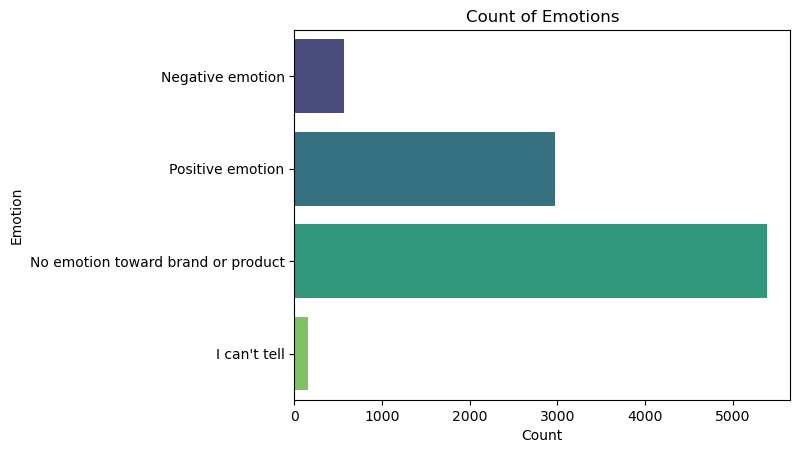

In [55]:
# Visualizing the emotion column
sns.countplot(y='emotion', data=df, palette='viridis')
plt.title('Count of Emotions')
plt.xlabel('Count')
plt.ylabel('Emotion')
plt.show()

- The most frequently occurring emotion is `No emotion toward brand or product`, with a count of .
Mention Less Frequent Emotions: "Other emotions, such as `4568` and `I can't tell`, are less common.

- There is a noticeable disparity between the counts of No emotion toward brand or product (4568) and the other emotions, with Positive emotion being the next most frequent at 2527, and Negative emotion at 501.


- The high frequency of No emotion toward brand or product might be attributed to users sharing informational or factual content about the products rather than personal opinions or emotional responses.

#### A histogram

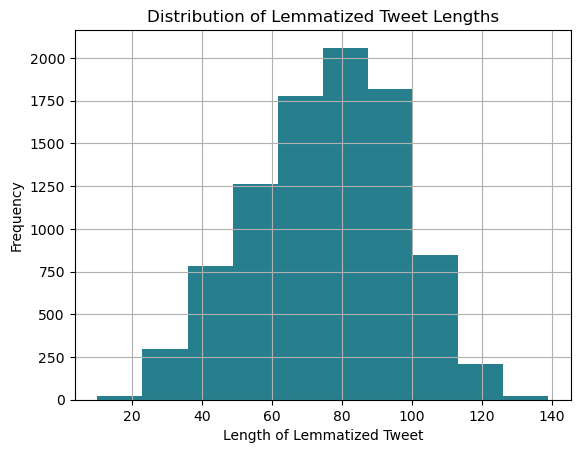

In [56]:
# Plotting a histogram to visualize the `lemmatized tweet` column
colors = sns.color_palette("viridis")  # Get the viridis palette
df['lemmatized_tweet'].str.len().hist(color=colors[2])  # Use the second color (green)
plt.xlabel('Length of Lemmatized Tweet')
plt.ylabel('Frequency')
plt.title('Distribution of Lemmatized Tweet Lengths')
plt.show()

The histogram shows that news `lemmatized tweet` range from 10 to 140 characters  

**A histogram to visualize the average length of words in google and apple products tweets**

The overall average word length is: 5.222132620167922


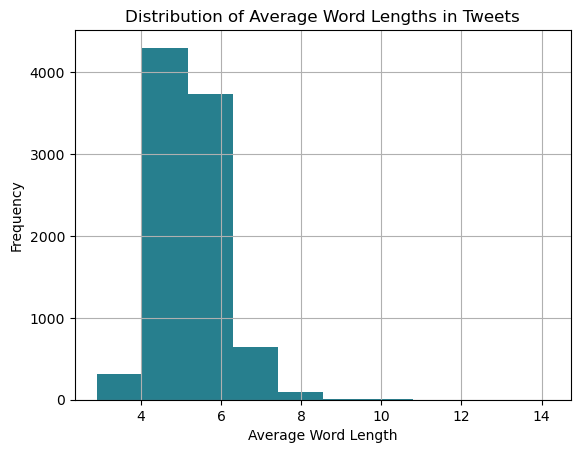

In [57]:
# A histogram to visualize the average length of words in google and apple products tweets
"""
calculates the average word length for each tweet, and then creates a
histogram to display the distribution of these average word lengths.
"""

# Handle potential float values in 'lemmatized_tweet' column
df['lemmatized_tweet'] = df['lemmatized_tweet'].astype(str)

# Calculate average word lengths and plot histogram with viridis palette
colors = sns.color_palette("viridis")
df['lemmatized_tweet'].str.split().\
   apply(lambda x : [len(i) for i in x]).\
   map(lambda x: np.mean(x)).hist(color=colors[2]); # Use the second color in the viridis palette

# calculating average word lengths

average_word_lengths = df['lemmatized_tweet'].str.split().\
   apply(lambda x : [len(i) for i in x]).\
   map(lambda x: np.mean(x))

overall_average = average_word_lengths.mean()

print("The overall average word length is:", overall_average)

plt.xlabel('Average Word Length')
plt.ylabel('Frequency')
plt.title('Distribution of Average Word Lengths in Tweets')
plt.show()

The histogram shows that the average word length in these tweets is around 5 words, with most tweets falling within the range of 4-5.   

**Most frequent Bargrams used in the dataset**

In [58]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

Text(0.5, 1.0, 'Top 5 Most Frequent Bigrams')

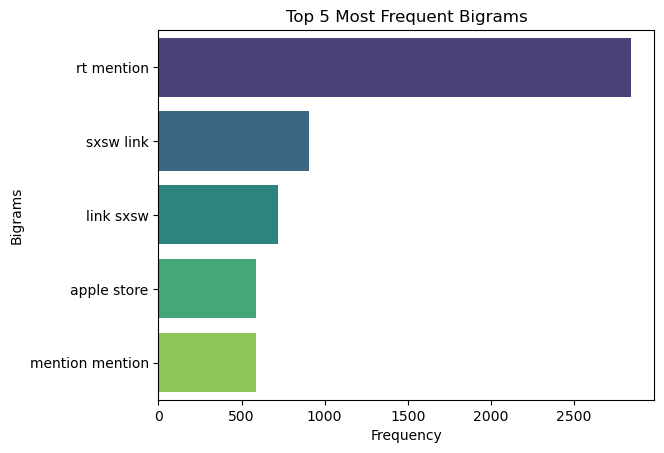

In [59]:
top_n_bigrams=get_top_ngram(df['lemmatized_tweet'],2)[:5]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x, palette='viridis')
plt.xlabel('Frequency')  # Label for the x-axis
plt.ylabel('Bigrams')   # Label for the y-axis
plt.title('Top 5 Most Frequent Bigrams') #Title

We can observe that the bigrams such as `rt mention` is mostly related to  dominate the news headlines.The presence of bigrams such as "rt mention" dominating the dataset suggests that many tweets are retweets or mentions, which are typically used to highlight trending topics, news, and user opinions. This can imply that discussions about Apple and Google products are significantly influenced by social sharing and user interactions on the platform

Note: you may need to restart the kernel to use updated packages.


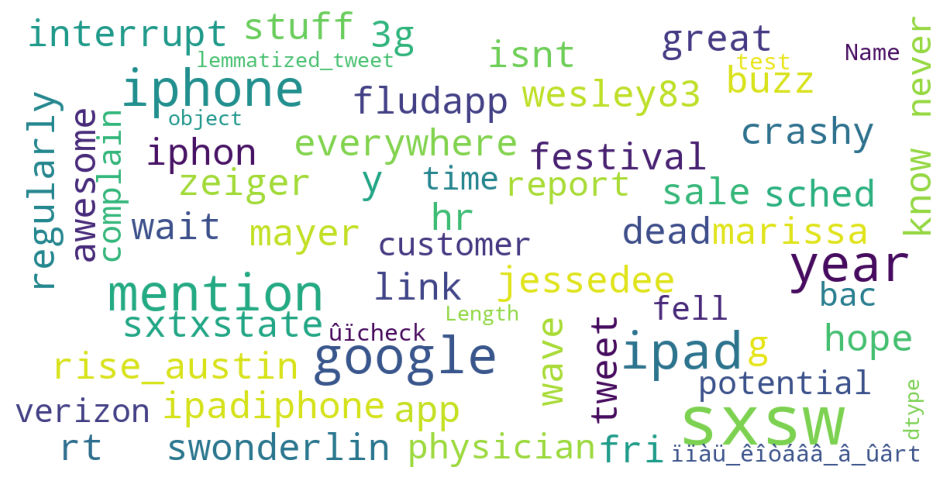

In [60]:
%pip install wordcloud

from nltk import corpus
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

# show_wordcloud(corpus)
show_wordcloud(df['lemmatized_tweet'])

The large words in the word cloud provide a snapshot of the key topics and sentiments in our dataset. By focusing on these prominent terms, we can gain insights into user opinions, event influences, and brand mentions, which are crucial for the analysis of sentiment towards Apple and Google products.

In [61]:
df['word_length'] = df['lemmatized_tweet'].str.split().apply(lambda x: [len(i) for i in x])
df

,tweet,product,emotion,cleaned_tweet,tokenized_tweet,removed_stop_tweet,pos_tagged,lemmatized_tweet,word_length
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,wesley83 i have a 3g iphone after 3 hrs tweeti...,"['wesley83', 'i', 'have', 'a', '3g', 'iphone',...","['wesley83', '3g', 'iphone', '3', 'hrs', 'twee...","[('wesley83', 'NN'), ('3g', 'CD'), ('iphone', ...",wesley83 3g iphone 3 hr tweet rise_austin dead...,"[8, 2, 6, 1, 2, 5, 11, 4, 4, 7, 6, 7, 4]"
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,jessedee know about fludapp awesome ipadiphone...,"['jessedee', 'know', 'about', 'fludapp', 'awes...","['jessedee', 'know', 'fludapp', 'awesome', 'ip...","[('jessedee', 'NN'), ('know', 'VBP'), ('fludap...",jessedee know fludapp awesome ipadiphone app y...,"[8, 4, 7, 7, 10, 3, 5, 6, 10, 6, 4, 6, 4, 4, 1..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,swonderlin can not wait for ipad 2 also they s...,"['swonderlin', 'can', 'not', 'wait', 'for', 'i...","['swonderlin', 'wait', 'ipad', '2', 'also', 's...","[('swonderlin', 'NN'), ('wait', 'NN'), ('ipad'...",swonderlin wait ipad 2 also sale sxsw,"[10, 4, 4, 1, 4, 4, 4]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,sxsw i hope this years festival isnt as crashy...,"['sxsw', 'i', 'hope', 'this', 'years', 'festiv...","['sxsw', 'hope', 'years', 'festival', 'isnt', ...","[('sxsw', 'JJ'), ('hope', 'NN'), ('years', 'NN...",sxsw hope year festival isnt crashy year iphon...,"[4, 4, 4, 8, 4, 6, 4, 6, 3, 4]"
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,sxtxstate great stuff on fri sxsw marissa maye...,"['sxtxstate', 'great', 'stuff', 'on', 'fri', '...","['sxtxstate', 'great', 'stuff', 'fri', 'sxsw',...","[('sxtxstate', 'NN'), ('great', 'JJ'), ('stuff...",sxtxstate great stuff fri sxsw marissa mayer g...,"[9, 5, 5, 3, 4, 7, 5, 6, 3, 7, 4, 16, 3, 4, 9, 9]"
...,...,...,...,...,...,...,...,...,...
9087,Ipad everywhere. #SXSW {link},iPad,Positive emotion,ipad everywhere sxsw link,"['ipad', 'everywhere', 'sxsw', 'link']","['ipad', 'everywhere', 'sxsw', 'link']","[('ipad', 'NN'), ('everywhere', 'RB'), ('sxsw'...",ipad everywhere sxsw link,"[4, 10, 4, 4]"
9088,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product,wave buzz rt mention we interrupt your regular...,"['wave', 'buzz', 'rt', 'mention', 'we', 'inter...","['wave', 'buzz', 'rt', 'mention', 'interrupt',...","[('wave', 'NN'), ('buzz', 'NN'), ('rt', 'NN'),...",wave buzz rt mention interrupt regularly sched...,"[4, 4, 2, 7, 9, 9, 8, 4, 4, 7, 3, 4, 4, 6, 6]"
9089,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product,googles zeiger a physician never reported pote...,"['googles', 'zeiger', 'a', 'physician', 'never...","['googles', 'zeiger', 'physician', 'never', 'r...","[('googles', 'NNS'), ('zeiger', 'RBR'), ('phys...",google zeiger physician never report potential...,"[6, 6, 9, 5, 6, 9, 2, 3, 3, 6, 9, 8, 7, 4, 8, ..."
9090,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product,some verizon iphone customers complained their...,"['some', 'verizon', 'iphone', 'customers', 'co...","['verizon', 'iphone', 'customers', 'complained...","[('verizon', 'NN'), ('iphone', 'NN'), ('custom...",verizon iphone customer complain time fell bac...,"[7, 6, 8, 8, 4, 4, 4, 4, 7, 6, 3, 7, 6, 4]"
